<a href="https://colab.research.google.com/github/junaid5/image-clustering-with-unsupervised-data/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing libraries
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, UpSampling2D, Activation
from keras import backend as K
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.datasets import mnist
import zipfile
import tensorflow as tf
import glob
from skimage.io import imread
from skimage.transform import resize

In [ ]:
local_zip = '/tmp/dataset.zip' #loading data set
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
img_list = sorted(glob.glob('/tmp/dataset/*.jpg')) #converting images to numpy arrays

IMG_SIZE = 152
x_data=np.empty((len(img_list),IMG_SIZE,IMG_SIZE,3),dtype=np.float32)

for i,img_path in enumerate(img_list):
  img = imread(img_path)
  img = resize(img, output_shape=(IMG_SIZE,IMG_SIZE,3),preserve_range=True)
  x_data[i] = img

In [ ]:
X_train, X_test = train_test_split(x_data,test_size=0.2, random_state=123) #splitting the data to training,testing and validation
X_train, X_validate= train_test_split(X_train, test_size=0.25, random_state=123)


In [ ]:
X_test=X_test/255 #preprocessing the data
X_train=X_train/255
X_validate=X_validate/255

In [ ]:
#using the autoencoder which consist of the first part as encoder and the second part as the decoder
#encoders are used to extract the features of the images as they are passed down from one layer to another
#and the features are extracted from the embedded layer i.e 7th layer. 
model = Sequential()
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu', input_shape=(152,152,3)))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D((2,2), padding='same'))#embedded layer
model.add(Dropout(0.2))#decoder starts from here
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(1, kernel_size=3, padding='same', activation='relu'))

In [ ]:
model.summary()#summary of the model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 152, 152, 8)       224       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 76, 76, 8)         0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 76, 76, 8)         0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 76, 76, 8)         584       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 38, 38, 8)         0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 38, 38, 8)        

In [ ]:
#compiling the model using adam optimizer with a learning rate=0.001 and the loss function is mean squared error which is optimal for classifying.
model.compile(optimizer='adam', loss="mse",metrics=['accuracy'])


In [ ]:
#training the model
model.fit(X_train, X_train, epochs=20, batch_size=40, validation_data=(X_validate, X_validate), verbose=1)

Epoch 1/20
72/72 [==============================] - 97s 1s/step - loss: 0.0235 - accuracy: 0.0024 - val_loss: 0.0294 - val_accuracy: 0.0023
Epoch 2/20
72/72 [==============================] - 96s 1s/step - loss: 0.0229 - accuracy: 0.0024 - val_loss: 0.0281 - val_accuracy: 0.0023
Epoch 3/20
72/72 [==============================] - 96s 1s/step - loss: 0.0224 - accuracy: 0.0024 - val_loss: 0.0264 - val_accuracy: 0.0023
Epoch 4/20
72/72 [==============================] - 99s 1s/step - loss: 0.0220 - accuracy: 0.0024 - val_loss: 0.0267 - val_accuracy: 0.0023
Epoch 5/20
72/72 [==============================] - 99s 1s/step - loss: 0.0215 - accuracy: 0.0024 - val_loss: 0.0259 - val_accuracy: 0.0023
Epoch 6/20
72/72 [==============================] - 97s 1s/step - loss: 0.0212 - accuracy: 0.0024 - val_loss: 0.0242 - val_accuracy: 0.0023
Epoch 7/20
72/72 [==============================] - 98s 1s/step - loss: 0.0209 - accuracy: 0.0024 - val_loss: 0.0244 - val_accuracy: 0.0023
Epoch 8/20
72/72 [==

In [ ]:
#restoring the original image in order to maintain the structure of the images.
restored_testing_dataset = model.predict(X_test)


In [ ]:
#extracting the features from embedded layer
encoder = K.function([model.layers[0].input], [model.layers[8].output])

In [ ]:
#encoding the x_test images in order to be trained in kmeans algorithm
encoded_images = encoder([X_test])[0].reshape(-1,19*19*8)

In [ ]:
#training the extracted features of image in the kmeans algorithm
kmeans = KMeans(n_clusters=7,max_iter=2000)
clustered_training_set = kmeans.fit_predict(encoded_images)

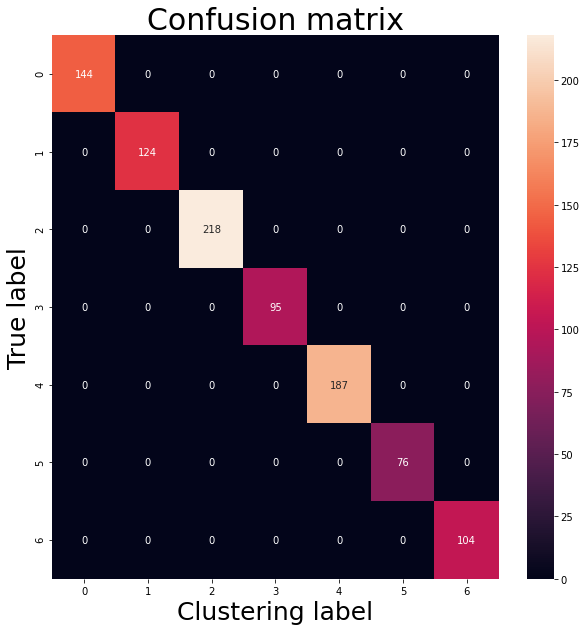

In [ ]:
#plotting the confusion matrix to identify the number of images classified as correct
cm = confusion_matrix(clustered_training_set, clustered_training_set)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [ ]:
#importing the image as input in order to identify the images belonging to the same cluster as outout
from google.colab import files
from keras.preprocessing import image
uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(152, 152,3))
  x=image.img_to_array(img)
  images = np.vstack([x])
  images=images.reshape(-1,152,152,3)/255
  enco = encoder([images])[0].reshape(-1,19*19*8)
  r=kmeans.predict(enco)

Saving tiger-2535888_640.jpg to tiger-2535888_640 (10).jpg


In [ ]:
print(r)

[3]


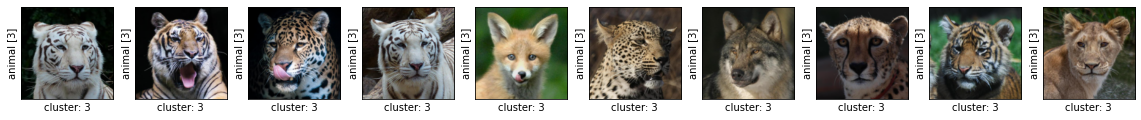

In [ ]:
#plotting the images belonging to the same cluster as input
fig = plt.figure(figsize=(20,20))
cluster = cm[r].argmax()
for c, val in enumerate(X_test[clustered_training_set == cluster][0:10]):
  fig.add_subplot(10, 10,10+c+1)
  plt.imshow(val.reshape((152,152,3)))
  plt.gray()
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('cluster: '+str(cluster))
  plt.ylabel('animal '+str(r))